In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

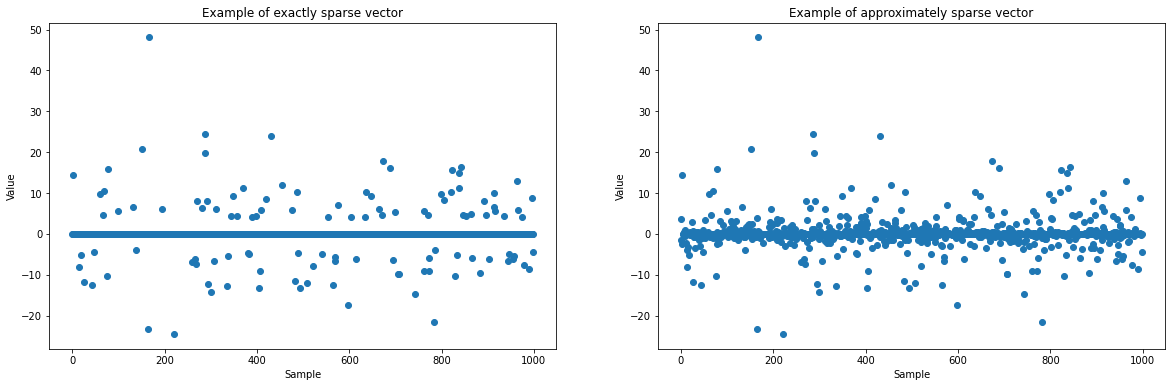

In [2]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

**1)** What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

Un signal exactement clairsemé va avoir un support de cardinal faible par rapport au nombre d'échantillons. C'est-à-dire qu'un nombre important d'échantillons sont exactement nuls. Pour un signal approximativement clairesemé on va se donner une marge sur ce qui est considéré comme un échantillon nul. 

**2)** Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

On obtient bien une figure en forme d'étoile. En effet comme les sources sont sparses on a beaucoup de valeurs vers (0,0). Les branches de l'étoiles correspondent aux valeurs de la forme (0,x) et (y,0) pour la même raison.

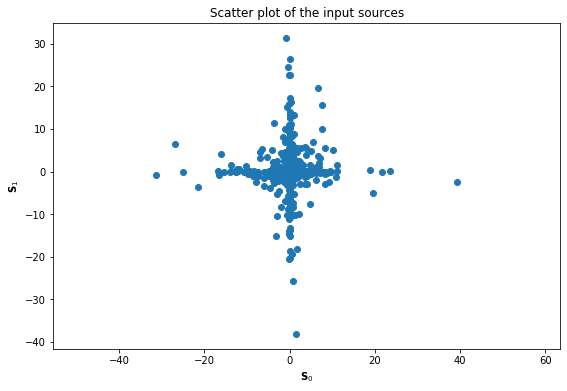

In [3]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 120 # noise level, in dB
power = 3 # power exponent used in the source generation

# TO DO : generate a simulated source S matrix. 
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse 
# law we used above.
S = np.random.randn(n,t)**power # TO CHANGE

#S = S*(np.abs(S)>4)

# TO DO : interpret the shape of the scatter plot you obtain
fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

In [4]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S  
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

# To be more realistic, we add some noise to the mixing. 
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120: 
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

Les directions des flèches correspondent aux 2 premiers axes principaux données par la matrice de mélange.
Plus la puissance est élevée plus les signaux sont sparses et donc moins l'influence du bruit est importante. 
Aussi plus le bruit est élevé, moins les signaux sont sparses et donc plus le mélange va brouiller les données. On perd la structure en étoile.

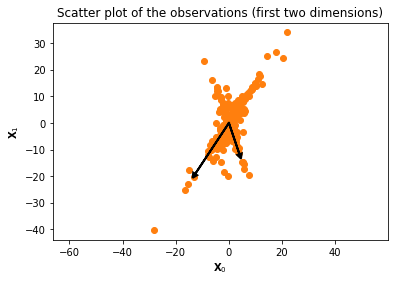

In [5]:
# TO DO : plot the scatter plot of X. What do you see ? 
# What do the directions of the lines you observe correspond ?
# Try several A matrices, noise_values and powers. Note your comments.

plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

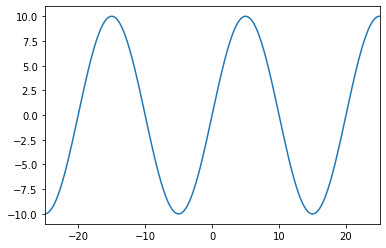

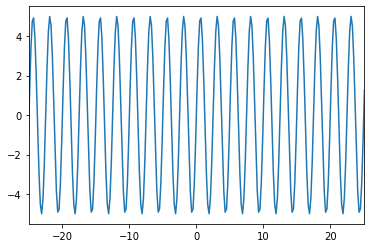

In [6]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

f0 = 0.05
f1 = 0.4
S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*f0*x_abs)
S[1,:] = 5*np.sin(2*np.pi*f1*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

LA DCT permet de rendre les signaux sparses dans un autre espace et donc d'identifier plus facilement les fréquences qui les composent. On retrouve des pics au niveau des fréquences du signal, avec un léger décalage que je ne parviens pas à expliquer.

f0= 0.05 and f1= 0.4
We find the frequency f0 = 0.06  and f1 = 0.5


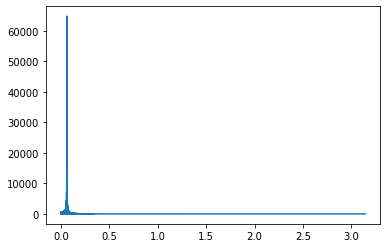

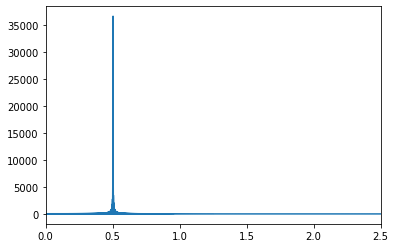

0.06314601233715485


In [7]:
# Transformation into the DCT domain
Sf = sff.dct(S)
# TO DO : what is the objective of using the DCT?
# TO DO : plot the above DCT and justify what you see? Pay attention to the labeling of the x-axis. Try with sinus of various frequencies.

k = np.linspace(0,t-1,t)
x = np.pi/t * k

print("f0=",f0,'and f1=',f1)
print("We find the frequency f0 =",np.round(x[np.argmax(np.abs(Sf[0,:]))],2)," and f1 =",np.round(x[np.argmax(np.abs(Sf[1,:]))],2))

plt.plot(x,np.abs(Sf[0,:]))
plt.show()
plt.plot(x,np.abs(Sf[1,:]))
plt.xlim(0,2.5)
plt.show()

print(x[np.argmax(np.abs(Sf[0,:]))])

Le mélange fait que l'on n'est plus en mesure de distinguer le signal comme une somme de deux sinus.
En revanche en utilisant la DCT on est mesure de déterminer les fréquences qui forment le signal ainsi que leurs amplitudes relatives. On est ainsi en mesure de reconstruire S et A à un facteur multiplicatif près.

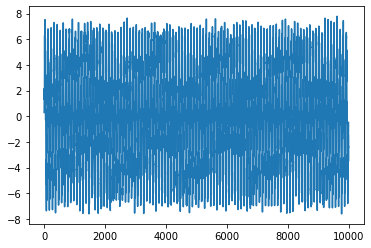

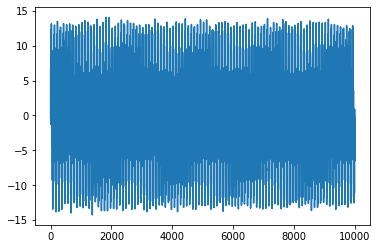

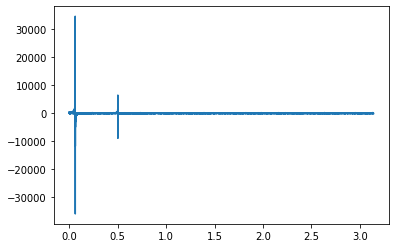

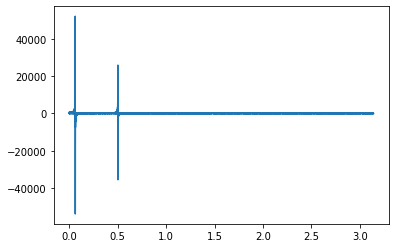

In [8]:
# Data generation : now, we will create a mixture X = AS + N

A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A value, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values

# TO DO : plot the mixtures. Explain what you see.

plt.plot(X[0,:])
plt.show()
plt.plot(X[1,:])
plt.show()
# TO DO : compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

Xf = sff.dct(X)


k = np.linspace(0,t-1,t)
x = np.pi/t * k

plt.plot(x,(Xf[0,:]))
plt.show()
plt.plot(x,(Xf[1,:]))
plt.show()

**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

**2-1)** First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?


On cherche à minimiser sur $S$ ,$ ||X - AS||^2 + \lambda ||S||_1 $. Le premier terme correspond à l'attache aux données tandis que le second assure que la solution est bien sparse. Cette fonction est convexe mais n'est pas dérivable partout à cause de la norme 1.

**2-2)** Compute the gradient along the S variable of the data-fidelity term.

On a $ \nabla_S ( ||X - AS||^2) = -A^T(X-AS) $

**2-3)**

Recall what the proximal operator of the l1-norm is.

On  a
$
\text{prox}_{\lambda||.||_1}(S)_i = \left\{
    \begin{array}{lll}
        s_i - \lambda & \mbox{si } s_i \ge \lambda \\
        0 & \mbox{si } |s_i| \le 1 \\
        s_i + \lambda & \mbox{si } s_i \le -\lambda \\
    \end{array}
\right.
$

In [9]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
#def prox_l1(S_est,thrd):
#  # To complete
#return S_est

def prox_l1(S_est, thrd):
    
    S_est[S_est>thrd] -=  thrd
    S_est[S_est<-thrd] += thrd
    S_est[abs(S_est)<=thrd] = 0

    return S_est

**2-4)** In your report, explain the main idea of the ISTA algorithm. Then, implement it.

L'ISTA est un algorithme qui permet de minimiser la fonction de cout. On fait une descente de gradient sur le terme d'attache aux données et ensuite on minimise en s'assurant de la sparsity.

In [10]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X,A = np.eye(2),n=2,lamb=0,nbIt = 100):
    
    k=0
    gamma = 0.9/ np.linalg.norm(A.T@A)
    
    S_est = np.zeros((n, X.shape[1]))
    
    while k< nbIt :
        S_est = prox_l1(S_est + gamma * A.T @ (X-A@S_est), gamma*lamb)
        
        k += 1
    return S_est

**2-5)** It's now time to play with the code : launch the ISTA algorithm and look at the results.

Si $\lambda$ est trop élevé la contraite de spasity est si importante que l'on a un résultat nul. Au contraire s'il est trop faible cette contrainte est levée et on a plus de bruit dans le résultat. Au final avec de bonnes valeurs de $\lambda$ on retrouve bien des sources sparses dans le domaine de la DCT avec des pics aux bonnes fréquences.

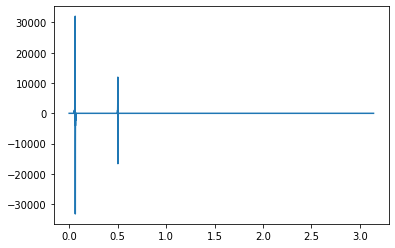

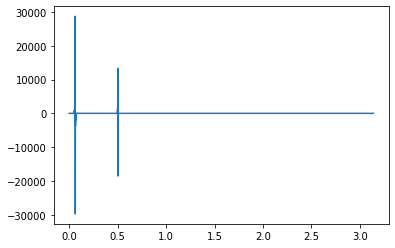

In [15]:
# TO DO : try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?
S_estf = ISTA(Xf,A = A,n=2,lamb=1000,nbIt = 1000)

# Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?
plt.plot(x,S_estf[0,:])
plt.show()
plt.plot(x,S_estf[1,:])
plt.show()

**2-6)** Transform the sources back in the direct domain. What do you see? Conclude.

On constate tout d'abord que le signal est mal reconstitué sur les bords, c'est une des limites de la DCT. Par contre lorsque que l'on regarde le centre on constate que l'on a bien retrouvé le signal. Néanmoins il faut prendre gare au fait que le résultat est bon à un facteur multiplicatif près.

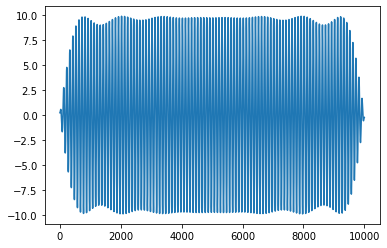

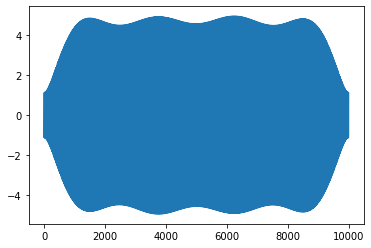

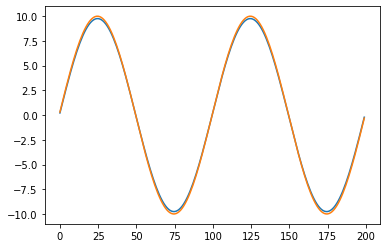

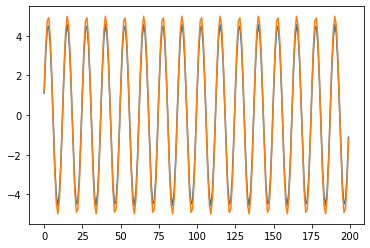

In [12]:
# TO DO : transform the estimated sources in the direct domain? Plot them. Explain the differences with the original sources you observe.


S_tdomain = sff.idct(S_estf)/20000


plt.plot(S_tdomain[0,:])
plt.show()
plt.plot(S_tdomain[1,:])
plt.show()

# TO DO : compare the central parts of the original and estimated sources.

center = 100


plt.plot(S_tdomain[0,5000-center:5000+center])
plt.plot(S[0,5000-center:5000+center])
plt.show()
plt.plot(S_tdomain[1,5000-center:5000+center])
plt.plot(S[1,5000-center:5000+center])
plt.show()

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

1) Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?




On cherche à minimiser sur A et S 
$$
\frac{1}{2}||X-AS||^2 + \lambda ||S||_1 + \mathbb{1}_{||a_{:,j}||_2^2 \le 1 }(A)
$$

On a le terme d'attache aux données, la contrainte de sparsity et la contrainte sur A qui empêche d'avoir des solutions dégénérées. Seul le premier terme est dérivable partout. De plus à cause du dernier terme la fonction n'est pas convexe.

2) Recall what the gradient of the data fidelity term over A is.


On a $ \nabla_A ( ||X - AS||^2) = -(X-AS)S^T $

3) Compte the proximal operator of the oblique constraint. Implement it.

In [13]:
def prox_oblique(A):
    for j in range(A.shape[1]):
        A[:,j] /= np.linalg.norm(A[:,j])
    return A

4) Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [14]:
def PALM(X,n=2,lamb=0,nbIt = 100):        
    
    A_est = np.random.rand(X.shape[0], n)
    S_est = np.random.rand(n, X.shape[1])
    k=0
    
    while k < nbIt:
                
        gamma = 0.9/np.linalg.norm(A_est@(A_est.T))
        eta = 0.9/np.linalg.norm(S_est@(S_est.T))
        
        S_est = prox_l1(S_est + gamma * A_est.T @ (X-A_est@S_est), lamb)
        A_est = prox_oblique( A_est + eta * (X-A_est@S_est)@S_est.T)
        
        k+=1
    
    return A_est,S_est

5) Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

In [27]:
A_est, S_est = PALM(Xf,n=2,lamb=5000,nbIt = 100)

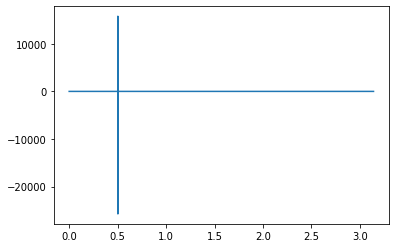

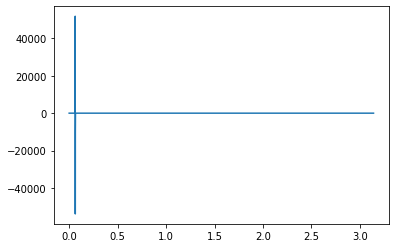

In [28]:
plt.plot(x,S_est[0,:])
plt.show()
plt.plot(x,S_est[1,:])
plt.show()

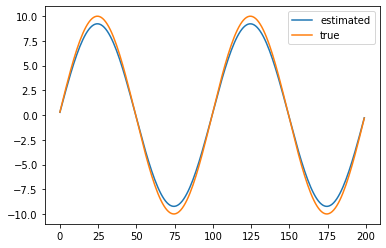

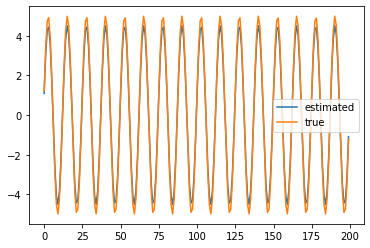

In [30]:
S_tdomain = sff.idct(S_est)
S_tdomain = S_tdomain/np.max(S_tdomain) * np.max(S)
center = 100

plt.plot(S_tdomain[1,5000-center:5000+center],label='estimated')
plt.plot(S[0,5000-center:5000+center],label='true')
plt.legend()
plt.show()
plt.plot(S_tdomain[0,5000-center:5000+center],label="estimated")
plt.plot(S[1,5000-center:5000+center],label='true')
plt.legend()
plt.show()

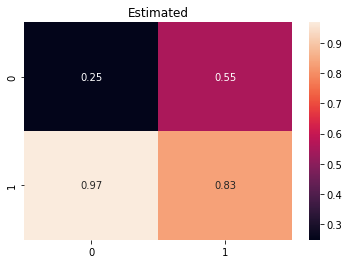

Text(0.5, 1.0, 'True')

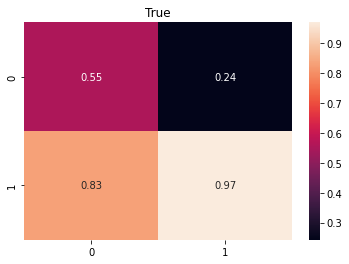

In [36]:
import seaborn as sn
sn.heatmap(A_est,annot=True)
plt.title("Estimated")
plt.show()
sn.heatmap(A,annot=True)
plt.title("True")